# ADAMS Tutorial #4: Neural Networking (NN) Primer
## Part 3 of 3

This is the final of three notebooks which will cover the foundations of neural networks. Please review the first two notebooks if you haven't yet, as this notebook assumes you understand the first two. In the first notebook, we discussed how the algorithm can be initialized randomly. The second notebook focused on training the network through back propagation. Training is the process in which we update the weights to maximize the fit of our network to training data. Network training is, therefore, equivalent to maximum likelihood estimation in regression analysis. 

This notebook will explore a different problem that neural networks are well-suited to solve: classification. We will be rewiring the same code form part 2, only this time, our network will classify samples. Differences will be explained as we go.

## This notebook's topic: Adapting what we know for a classification network ##
 1. Reviewing classification problems
 2. Highlighting differences in the algorithm
 3. Revising our code to solve a classification problem
 4. A cheat sheet for the most basic neural network problems

In [1]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
range_for_demo = np.linspace(-5, 5, 100)

import random
random.seed(888)  # set seed for reproducibility
np.random.seed(888)

from sklearn.datasets import make_blobs
from matplotlib import pyplot
import pandas as pd
import numpy as np

# Types of classification problems

There are a few types of problems which require us to label the classes of data. Here is a quick summary:

**Binary classification** tries to predict which of two options is most likely. For example, will this customer spend money today (yes/no)? Will rain fall today (yes/no)?
 - Single dummy: binary target coded as a single binary variable representing the probability of an event occurring or label 1 (eg. one variable for purchase, no purchase is inferred as the inverse)
 - Two-dummy: one dummy is the probability of the non-event/label 0, the second being the probability of the event/label 1 (eg. one variable for no purchase and one variable for purchase)

In [2]:
# single dummy approach
Y = [1, 0, 1]

# two-dummy approach (same information as the single dummy above)
Y_0 = [0, 1, 0]
Y_1 = [1, 0, 1]  # note that this vector is identical to single dummy

**Single label multi-class classification** tries to predict which of 3 or more options are most likely but only ONE class is possible. Eg. Is this image a cat, dog or bird? It is recommended to one-hot encode the target variable.

**Multiple label multi-class classification** tries to predict which of 3 or more options are most likely and when multiple classes are possible. Eg. Which of these products will be purchased? It is recommended to one-hot encode the target variable.

# Differences in NNs for binary classification

## Toy Data Generation: Binary Classification

We will now need some new data for this example. We are going to generate two variables with conditional impacts on our target variable. There will be two clusters and each variable will have a slightly different mean per cluster. In order to compare this to a real-world example, it would be a situation where we have two distinct groups. In our previous example in the last notebooks on regression, we said that the target could represent the grade on the final exam. This time, we could say that these two groups represented those who passed and didn't pass a test. Again, one of our variables could represent average hours slept per night and the other could be an indicator for if the student completed the assignments in class. What's important here is that we are predicting membership in one of two groups and not a continuous number.

In [2]:
n = 10000 # generate number of observations
k = 2  # number of features

XX, Y = make_blobs(n_samples=n, n_features=k, centers=2, random_state=888, cluster_std=1.5)

Y = Y.reshape(n,1)

## Network architecture
For the most part, the network architecture required for binary classification networks is very similar to those required for regression networks. Our input layer has just as many neurons as we have features and we have a hidden layer whose size we can experiment with. We could also experiment with adding more hidden layers. One of the only main differences concerns the size of the output layer. Note that There are specific sizes based on the values of your target variable as explained below.

### Output layer size
For regression problems, we had a constant output layer size of 1 neuron because we were only predicting one number.

For **binary classification** problems where the target is coded as a single dummy variable, you will need 1 node in your output layer. If there are two dummy variables for the target (one dummy for class 0 and one dummy for class 1), you will need 2 nodes. In our example, we have coded everything as a single dummy variable.

In [3]:
# Network architecture:
inputLayer_size = 2      # number of features in X, in this case we only have 2
hiddenLayer_size = 10    # number of hidden layer nodes
outputLayer_size = 1     # number of values to predict, in this case, our target is one vector

As before, for the initialization, we will only take the 5th observation in the dataset.

In [4]:
X = np.array(XX[5]).reshape((inputLayer_size, 1))
X.shape  # This should be kx1

(2, 1)

In [5]:
y = Y[5].reshape((outputLayer_size, 1))
y.shape  # since our target is coded as a single dummy variable, we should see (1, 1) here

(1, 1)

## Weight initialization
As in part 1 and 2, we randomly initialize weights based on the recommendation we received from Glorot and Bengio (2010). The only thing to be careful of as we refit this network for a classification problem is the size of the output layer which we have already discussed.

In [6]:
limit = np.sqrt(6 / (inputLayer_size + outputLayer_size))  # Recommended weight initialization

# Random weight and bias initialization
W_0 = np.random.uniform(-limit, limit, (hiddenLayer_size, inputLayer_size))    # input to hidden layer weights
W_1 = np.random.uniform(-limit, limit, (outputLayer_size, hiddenLayer_size))  # hidden to output layer weights

B_0 = np.ones((hiddenLayer_size,1))  # input to hiden layer biases
B_1 = np.ones((outputLayer_size,1))  # hidden to output layer biases

In [7]:
Z_hidden = np.dot(W_0, X) + B_0
Z_hidden[:5]  # these are the first five nodes' input values

array([[15.25580764],
       [-6.27077088],
       [ 6.47240459],
       [ 8.81335129],
       [-8.51333128]])

## Activation functions

Remember that you should distinguish your activation functions in two groups:
- Hidden layer activations: here you can experiment with any activation function but are encouraged to use the ones that we introduced in part 2.
- Final layer activation: this activation needs to suit your output. We mentioned using a linear activation for regression. Below we will discuss good final activations for classification.

For the **hidden layer** in our current network, let's take $tanh$ this time. If you are curious about this function and its derivatives, you can find an explanation in part 2.

In [8]:
# Activation function that we will use in this scenario and its derivative
def tanH(x):
    return (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))


def tanH_derivative(x):
    return 1-tanH(x)**2

In [9]:
H = tanH(Z_hidden)
H[:5]  # these are the first five nodes' output values (after activation)

array([[ 1.        ],
       [-0.99999285],
       [ 0.99999522],
       [ 0.99999996],
       [-0.99999992]])

### Final activation functions for classification problems

We talked about a few possible activation functions such as linear, ReLU, leaky ReLU, tanh and sigmoid. We can experiment with any of these if they are not in the final layer. However, we need to pay attention to the final layer's activation because it determines the range of values that will be output. 

#### Sigmoid and binary classification
**If your target is a single dummy**, you will need your network to output a value between 0 and 1 as the probability of class 1. The best final activation function for the output layer will be **sigmoid** whose outputs are always squeezed into a probability between 0 and 1. $tanh$ can also be used but note that it ranges between -1 and 1, so you will need to rescale it. If you would like to see a more detailed description of the sigmoid function including its derivation, you can find it in part 2 in this tutorial series.

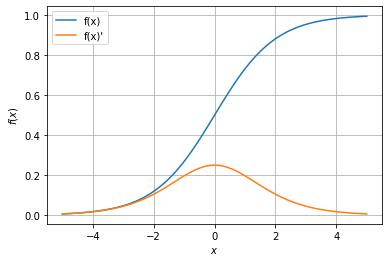

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1-s)

plt.plot(range_for_demo, sigmoid(range_for_demo), label='f(x)')
plt.plot(range_for_demo, sigmoid_derivative(range_for_demo), label="f(x)'")
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='best')
plt.show()

#### Softmax and binary classification

**If your target is two dummy variables**, you'll have 2 output neurons. The first neuron outputs the probability of class 0 and the second outputs the probability of class 1. We want the sum of the probability of both classes to be 1. In this case, we have a final activation function called **softmax** which will make sure the sum of probabilities in the output to be 1.

$$ \text{softmax}(x) = \frac{e^{x_i}}{\sum_{j=1} e^{x_j} } $$

#### Understanding the softmax output for derivation

This function takes a inputs $X$ as a vector and produces a vector of probabilities which sum to 1. Since we are predicting for classes, this vector will have the dimension of $ n\_class * 1$.

So, in essence, $\text{softmax}(x)$ does the following:
$$ \text{softmax} \bigg( \begin{bmatrix}  x_{1} \\  x_{2}\\   \vdots\\ x_{n}\\ \end {bmatrix} \bigg) \rightarrow
\begin{bmatrix}  s_{1} \\  s_{2} \\  \vdots \\ s_{n} \end {bmatrix} $$

If we want to derive this function, we will have to derive each output w.r.t. $x_1$ through $x_n$. This will create a Jacobian (square) matrix:
$$ \begin{bmatrix} \frac{\partial s_1}{\partial x_1} & \frac{\partial s_1}{\partial x_2} & \ldots \ & \frac{\partial s_1}{\partial x_n} \\ \frac{\partial s_2}{\partial x_1} & \frac{\partial s_2}{\partial x_2} \\  \vdots & \vdots \\  \frac{\partial s_1}{\partial x_n} & \frac{\partial s_n}{\partial x_2} & \ldots\ & \frac{\partial s_n}{\partial x_n} \\ \end{bmatrix} $$

#### Deriving the softmax

If we want to derive this function, we would have to use the quotient rule as we have done in many other calculations before.

$$\begin{aligned} &f(x) = \frac{g(x)}{h(x)} \\
& f'(x) = \frac{g'(x)h(x) - g(x)h'(x)}{[h(x)]^2} \end{aligned}$$

Here, $g(x)=e^{x_i}$ and $h(x)=\sum_{j=1} e^{x_j}$. There are two situations which we will have when we derive with respect to $x_j$.

Case 1: $i=j$ (Jacobian matrix diagonal)
$$g(x)=e^{x_j}$$
$$ \frac{\partial g(x)}{\partial x_j}=e^{x_j}$$

$$h(x)=\sum_{j=1} e^{x_j}$$
$$ \frac{\partial h(x)}{\partial x_j}=e^{x_j}$$

So, if we want to find the partial derivatives of the softmax function, we would need to do the following for this case:

$$\begin{aligned}
& = \frac{\partial \text{softmax}}{\partial x_j} \\
& = \frac{e^{x_j} \cdot \sum_{k=1} e^{x_k} - e^{x_j} \cdot e^{x_j}}{\big[ \sum_{k=1} e^{x_k} \big]^2 } \\
& = \frac{e^{x_j} \big( \sum_{k=1} e^{x_k} - e^{x_j} \big) } {\big[ \sum_{k=1} e^{x_k} \big]^2 } \\
& = \frac{e^{x_j}} { \sum_{k=1} e^{x_k} } \cdot \frac{\sum_{k=1} e^{x_k} - e^{x_j}}{ \sum_{k=1} e^{x_k} } \\
& = \text{softmax} (1- \text{softmax})\\
\end{aligned}$$

Case 2: $i \neq j$ (off-diagonal elements)
$$g(x)=e^{x_i}$$
$$ \frac{\partial g(x)}{\partial x_j}=0$$

$$h(x)=\sum_{j=1} e^{x_j}$$
$$ \frac{\partial h(x)}{\partial x_j}=e^{x_j}$$


And for this case, the derivative is:

$$\begin{aligned}
& = \frac{\partial \text{softmax}}{\partial x_j} \\
& = \frac{0 \cdot \sum_{k=1} e^{x_k} - e^{x_j} \cdot e^{x_i}}{\big[ \sum_{k=1} e^{x_k} \big]^2 } \\
& = - \frac{e^{x_j}}{\sum_{k=1} e^{x_k}} \cdot \frac{e^{x_i}}{\sum_{k=1} e^{x_k}} \\
& = - \text{softmax} \cdot \text{softmax}\\
\end{aligned}$$

Just like that, we can now use the softmax's gradient to solve a minimization.

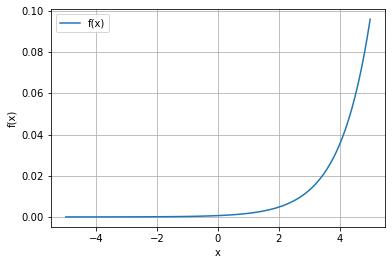

In [11]:
# Here we will only plot the function as the derivative is more complex
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

plt.plot(range_for_demo, softmax(range_for_demo), label="f(x)")
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

So, now let's continue through the first pass of our classification neural network. We will first calculate the input into the final layer:

In [12]:
Z_output = np.dot(W_1, H) + B_1  # Sum of next layer of weights*respective node then add bias
Z_output 

array([[-2.18882511]])

Now, we will apply a sigmoid function which will output a value between 0 and 1. This will represent probability of class 1 for the first forward pass. We can infer the probability of class 0 by finding the inverse of this, $1-\hat y$. We know that this will very likely be optimized through gradient descent shortly.

In [13]:
y_hat = sigmoid(Z_output)  # Apply activation for output layer's output
y_hat

array([[0.1007585]])

## Loss Functions for Classification

### Cross-Entropy
Entropy $H(y)$ is a term from Information Theory which signifies the optimal number of bits needed to encode a certain amount of information. $y_c$ is the probability of the nth event, or in our case, class:

$$H(y) = \sum_c y_c \cdot \log \frac{1}{y_c} = -\sum_c y_c \cdot \log y_c$$

Now the cross-entropy $H(y,\hat{y})$ is the number of bits we'll need to encode symbols from $y$ using the wrong tool $\hat{y}$. Cross-entropy is always bigger or equal to entropy. Mind that $c$ is the number of classes. 

$$H(y, \hat{y}) = \sum_c y_c \cdot \log \frac{1}{\hat{y}_c} = -\sum_c y_c \cdot \log \hat{y}_c$$

Interestingly enough, the The KL divergence that you have encountered before in BADS (uplift random forest) is simply the difference between cross-entropy and entropy:
$$\mbox{KL}(y~||~\hat{y})
= \sum_c y_c \log \frac{1}{\hat{y}_c} - \sum_c y_c \log \frac{1}{y_c}
= \sum_c y_c \log \frac{y_c}{\hat{y}_c}$$

We would be calculating cross-entropy for every pair of true/estimated probabilities and averaging it over the sample or batch - this will be our loss function *L* that we will ultimately want to minimize (class i, sample j):

$$L=-\frac{1}{n}\sum_i \sum_c y_{i,c} \log(\hat{y}_{i,c})$$

### Binary cross-entropy
For **binary classification**, we would use the special case of the equation above with 2 classes called binary cross-entropy (note there are other options like hinge loss).

$$L=-\frac{1}{n}\sum_i \big( y_{i,1}  \log(\hat{y}_{i,1}) + y_{i,2} \log(\hat{y}_{i,2}) \big) $$

#### Deriving the loss function
Now, we need to minimize the loss function. Let's derive the binary cross entropy function for a single observation. We will remove the $\frac{1}{n}$ since it can be divided out in the minimization:

$$\begin{aligned}
& = \frac{\partial L_i}{\partial w} \\
& = - \frac{\partial}{\partial w} y_{1}  \log(\hat{y}_{1}) + \frac{\partial}{\partial w}  y_{2} \log(\hat{y}_{2}) \\
\end{aligned}$$

At this point, it is important to remember three things at this point. The first is that the true values $y_i$ are just constants. Secondly, the estimates  $\hat y_i $ are a function determined by the sigmoid, so we use the chain rule on each $log(\hat y_i)$. Lastly, we also can replace $y_1$ with $y$ and $y_2$ with $1-y$ since we only have two probabilities/possibilities which are complements of each other. 

$$\begin{aligned}
& = - \frac{y_{1}}{\hat{y}_{1}} \cdot \frac{\partial}{\partial w}\hat{y}_{1} - \frac{y_{2}}{\hat{y}_{2}} \cdot \frac{\partial}{\partial w}\hat{y}_{2} \\
& = - \frac{y}{\hat{y}} \cdot \frac{\partial}{\partial w}\hat{y} - \frac{1-{y}}{1-\hat{y}} \cdot \frac{\partial}{\partial w} (1-\hat{y}) \\
& = - \frac{y}{\hat{y}} \cdot \frac{\partial}{\partial w}\hat{y} + \frac{1-{y}}{1-\hat{y}} \cdot \frac{\partial}{\partial w} \hat{y} \\
\end{aligned}$$


We know that the final equation which determines $\hat y$ is the final sigmoid activation. So, we can replace $\hat y$ with the sigmoid and derive it where necessary (full derivation in part 1 of these tutorials).


$$\begin{aligned}
& = - \frac{y}{\text{sigmoid}} \cdot \frac{\partial}{\partial w} \text{sigmoid} + \frac{1-{y}}{1-\text{sigmoid}} \cdot \frac{\partial}{\partial w} \text{sigmoid}  \\
& = - \frac{y}{\text{sigmoid}} \cdot \text{sigmoid}\cdot (1-\text{sigmoid}) + \frac{1-{y}}{1-\text{sigmoid}} \cdot (\text{sigmoid}\cdot (1-\text{sigmoid}))  \\
& = - y \cdot (1-\text{sigmoid}) + (1-y) \cdot \text{sigmoid} \\
& = - y + y \cdot \text{sigmoid} + \text{sigmoid}-y \cdot \text{sigmoid} \\
& = \text{sigmoid}-{y} \\
\end{aligned}$$

The sigmoid at the end is also the prediction, so that means: $$ = \text{sigmoid}-{y} = \hat{y}-{y} $$ The extreme simplicity of this function's derivative is what makes it so ideal for a loss function, especially when the number of calculations starts to grow in the optimization process.

In [14]:
# Define the binary cros entropy loss function
def bce(true, pred):
    eps = 1e-50 # small epsilon so that the log never tries to div by 0
    return - np.mean(
        np.multiply(true, np.log(pred + eps)) + np.multiply((1-true), np.log(1 - pred + eps)))

def bce_derivative(pred, true):
    return pred - true

Let's take a look at the intitial loss for observation 5, the derivative of the loss function and final activation function.

In [15]:
loss = bce(Y[5], y_hat)
loss

0.10620364398497029

And now the derivatives associated with the loss function and the final activation.

In [16]:
loss_derivative = bce_derivative(y_hat, Y[5])
loss_derivative

array([[0.1007585]])

In [17]:
final_activation_derivative = sigmoid_derivative(Z_output)
final_activation_derivative

array([[0.09060622]])

## Optimization based on loss
To continue, we can just use the code that we had in part 2. We just need to make sure that our chosen activation this time ($tanh$) is subsituted where appropriate. Again, we did not have to choose $tanh$ and you should experiment with other activations to optimize your model.

In [18]:
# Update weights furthest back in the network (between hidden and output layer)
gradient_HiddenToOutput = np.dot(loss_derivative*final_activation_derivative, np.transpose(H))
gradient_HiddenToOutput.shape

# Update output layer biases
gradient_HiddenToOutput_bias = loss_derivative*final_activation_derivative

# Save the error of the output layer
pred_errors = loss_derivative * final_activation_derivative

# Find gradient for next step for backpropagation: gradient to update weights between hidden and input layer
gradient_InputToHidden = np.dot(W_1.T, pred_errors)
print(f'Shape of first weights {W_1.shape}')

# Next propagation backwards: derivative of the hidden layer output wrt the hidden layer input (tanh derivative)
gradient_InputToHidden = gradient_InputToHidden * tanH_derivative(Z_hidden)
print(f'Shape of gradient vector {gradient_InputToHidden.shape}')

# Derivate of the hidden layer input wrt to the weight matrix connecting the hidden layer to inputs X
gradient_InputToHidden = np.dot(gradient_InputToHidden, np.transpose(X))
print(f'Shape of input {X.shape}')

# Last update: output layer biases
gradient_InputToHidden_bias = np.dot(W_1.T, pred_errors) * tanH_derivative(Z_hidden)

Shape of first weights (1, 10)
Shape of gradient vector (10, 1)
Shape of input (2, 1)


## Initial weight correction
Now that we have calculated our gradients, we can finally perform our first update! This process should be identical to what we saw in part 2. Just as before, we can set a different step size (learning rate) for this initial optimization step.

In [19]:
# Gradient descent step
learningRate = 0.1  # define some learning rate for first step

# Update weights between hidden and output layer (furthest back)
W_1 -= learningRate * gradient_HiddenToOutput
# Update bias in output layer
B_1 -= learningRate * gradient_HiddenToOutput_bias
# Update weights between input and hidden layer (furthest forward)
W_0 -= learningRate * gradient_InputToHidden
# Update bias in hidden layer
B_0 -= learningRate * gradient_InputToHidden_bias

With that, we have completed our first weight and bias update on this journey through neural network optimization. Now let's write review some code for batch gradient descent just as we did in part 2.

## Setting learning rate, epochs and batch sizes
As in part 2, we will need to set a few more parameters which we can adjust for better optimization of the network:
- Learning rate: how much the algorithm will move in the negative direction of the gradient, too large and we will likely overshoot a local minimum, too low and no improvement will be seen
- Epochs: how many rounds to train the model, too few could be too little for improvement, too many could cause the capture of too much noise in the data
- Batch size: the amount of observations that we will be randomly selecting for the optimization of our network, we will average their gradient and move in the direction of the average

In [20]:
learningRate = 0.02
epochs =  300  # stopping rule, how many corrective iterations we will allow
batch_size = 500

input_dim = XX.shape[1]  # number of variables
output_dim = 1  # should be equal to 1 since we are only finding the predicted value for 1 regression

## Rewire SGD for binary classification
Here is the code which includes the loops for batch gradient descent according to the number of allowed epochs at the specified learning rate with the specific batch size. The only spots here where you should see changes is the loss function and activation functions (along with their respective derivatives). We can then run the code to see if the error does start going down.

In [21]:
iteration = 0

loss_log = []

while iteration < epochs:

    # Process one batch of random observations per epoch/iteration
    random_batch = random.sample(range(0, XX.shape[0]), batch_size)  # choose observations for random batch

    HiddenToOutput_gradient_list = [] # to store the gradients based on each observation in batch
    InputToHidden_gradient_list = []

    # Update weights and biases one at a time with each random observation's error (all steps before, just in a loop together)
    for obs in random_batch:

        # Select feature values and target value for random observation
        X = np.array(XX[obs]).reshape((input_dim, 1))
        y = Y[obs].reshape((1, 1))

        # Compute the forward pass through the network all the way up to the final output
        Z_hidden = np.dot(W_0, X) + B_0
        H = tanH(Z_hidden)
        Z_output = np.dot(W_1, H) + B_1
        y_hat = sigmoid(Z_output)  # final activation is sigmoid instead of linear

        # Gradient for the weights between hidden and output layers
        gradient_HiddenToOutput = bce_derivative(Y[obs], y_hat) * sigmoid_derivative(y_hat) # use derivative of BCE loss and sigmoid
        pred_errors = gradient_HiddenToOutput

        # Gradient for the weights between input and hidden layers
        gradient_InputToHidden = np.dot(W_1.T, pred_errors) * tanH_derivative(Z_hidden)
        
        HiddenToOutput_gradient_list.append(gradient_HiddenToOutput)
        InputToHidden_gradient_list.append(gradient_InputToHidden)

    mean_gradient_HiddenToOutput = np.mean(HiddenToOutput_gradient_list, axis=0) # average optimal movemnt over batch
    mean_gradient_InputToHidden = np.mean(InputToHidden_gradient_list, axis=0)
    
    # Update biases according to learning rate and gradient
    B_1 -= learningRate * mean_gradient_HiddenToOutput
    B_0 -= learningRate * mean_gradient_InputToHidden

    # Update weights according to learning rate and gradient
    W_1 -= learningRate * np.dot(mean_gradient_HiddenToOutput, np.transpose(Z_hidden))
    W_0 -= learningRate * np.dot(mean_gradient_InputToHidden, np.transpose(X))
    
    # Check how well the model does on all observations by passing them through a forward pass with most up to date weights
    XX_reshaped = np.array(XX).reshape((inputLayer_size, n))  # all observations
    Y_reshaped = Y.reshape((outputLayer_size, n))
    Z_hidden = np.dot(W_0, XX_reshaped) + B_0  # first hidden layer inputs
    H = tanH(Z_hidden)  # hidden layer output (after activation)
    Z_output = np.dot(W_1, H) + B_1  # input to output layer
    Y_hat = sigmoid(Z_output) # Sigmoid output instead of linear
    
    # Calculate loss for entire model
    iteration_loss = bce(Y_reshaped, Y_hat) # Here are we are using BCE
    loss_log.append(iteration_loss)

    # Development of the loss as average over observation-level losses
    print(f'Epoch {iteration+1} with average error of {iteration_loss:.2f}.')
    iteration += 1

Epoch 1 with average error of 1.48.
Epoch 2 with average error of 1.48.
Epoch 3 with average error of 1.48.
Epoch 4 with average error of 1.48.
Epoch 5 with average error of 1.48.
Epoch 6 with average error of 1.48.
Epoch 7 with average error of 1.48.
Epoch 8 with average error of 1.48.
Epoch 9 with average error of 1.48.
Epoch 10 with average error of 1.48.
Epoch 11 with average error of 1.48.
Epoch 12 with average error of 1.48.
Epoch 13 with average error of 1.48.
Epoch 14 with average error of 1.48.
Epoch 15 with average error of 1.48.
Epoch 16 with average error of 1.48.
Epoch 17 with average error of 1.48.
Epoch 18 with average error of 1.47.
Epoch 19 with average error of 1.47.
Epoch 20 with average error of 1.47.
Epoch 21 with average error of 1.47.
Epoch 22 with average error of 1.47.
Epoch 23 with average error of 1.47.
Epoch 24 with average error of 1.47.
Epoch 25 with average error of 1.47.
Epoch 26 with average error of 1.47.
Epoch 27 with average error of 1.47.
Epoch 28 w

Epoch 224 with average error of 1.27.
Epoch 225 with average error of 1.27.
Epoch 226 with average error of 1.27.
Epoch 227 with average error of 1.27.
Epoch 228 with average error of 1.27.
Epoch 229 with average error of 1.27.
Epoch 230 with average error of 1.26.
Epoch 231 with average error of 1.26.
Epoch 232 with average error of 1.25.
Epoch 233 with average error of 1.25.
Epoch 234 with average error of 1.24.
Epoch 235 with average error of 1.24.
Epoch 236 with average error of 1.24.
Epoch 237 with average error of 1.24.
Epoch 238 with average error of 1.24.
Epoch 239 with average error of 1.25.
Epoch 240 with average error of 1.24.
Epoch 241 with average error of 1.24.
Epoch 242 with average error of 1.24.
Epoch 243 with average error of 1.24.
Epoch 244 with average error of 1.23.
Epoch 245 with average error of 1.23.
Epoch 246 with average error of 1.23.
Epoch 247 with average error of 1.22.
Epoch 248 with average error of 1.22.
Epoch 249 with average error of 1.23.
Epoch 250 wi

With this simple network, we can clearly see progress is being made! Not only that, hopefully you can now see the large similarities between classification and regression networks. They are highly related to each other, you only need to pay attention to: output layer size, final activation function and the loss function. Other than that, they are basically the same thing. There are of course many other powerful settings in more complex packages which you would be wise to explore. Creating a good neural network for a real task takes quite a lot of time and effort. This can be saved by using all the tools you have available to do so.

# Working with multi-class problems
Now that you have an understanding on how binary classification works, you should find the transition to multi-class problems to be not too difficult. There are really only a few things to keep in mind regarding the output layer size, the recommended final activations and the recommended loss functions. Other than that, the rest is pretty much identical.

### Output Layer
- Your output layer will need one node per class.


### Final Activation
- For **single label multi-class problems**: softmax as all class probabilities should sum to 1 since only one label is possible.
- For **multi-label multi-class problems**: sigmoid as there is no restriction on the sum of all probabilities since multiple labels are possible. 


### Loss functions
- For **single label multi-class problems**, you should use categorical cross-entropy or the generalized version of the equation for $ L $ above (categorical cross-entropy).
- For **multi-label multi-class problems**, you can use binary cross-entropy again because any label has its own probability.

# Cheat sheet for each scenario:

For **regression problems**:
- Make sure your output is 1 variable with any range
- Output layer should be size 1
- Output could be any number
- Final activation function: linear or ReLU
- Most popular loss function: MSE or MAE

For **binary classification problem with target coded as a single dummy vector**:
- Make sure your output is a single binary variable with values 0 and 1
- Output layer should be size 1
- Output will range from 0 to 1 and represent the probability of being class 1
- Final activation function: sigmoid
- Loss function: binary cross entropy

For **binary classification problem with target coded as two complementary dummies**:
- Make sure your output is two binary variables representing probabilities of class 0 and class 1
- Output layer should be size 2
- Output nodes will range from 0 to 1 and represent the probability of being class 0 and 1 respectively
- Final activation function: softmax
- Loss function: binary cross entropy

For **multiple possible classes but strictly 1 class per observation (single label)**:
- Make sure your output size is equivalent to the number of classes
- Each value for outputs must be between 0 and 1
- Output layer should be equivalent to the number of classes
- Output will range for each class from 0 to 1 and represent the probability of being that class
- Final activation: softmax
- Loss function: categorical cross entropy

For **multiple possible classes and multiple classes per observation are possible (multi-label)**:
- Make sure your output size is equivalent to the number of classes
- Each value for outputs must be between 0 and 1
- Output layer should be equivalent to the number of classes
- Output will range for each class from 0 to 1 and represent the probability of being that class
- Final activation: sigmoid
- Loss function: binary cross entropy